# Recurrent Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Importing the Dataset

In [2]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


## Exploratory Data analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,533.709833,151.904442,279.12,404.115,537.47,654.9225,816.68
High,1258.0,537.880223,153.008811,281.21,406.765,540.75,662.5875,816.68
Low,1258.0,529.007409,150.552807,277.22,401.765,532.99,644.8000,805.14


In [6]:
df.corr()['Open']

Open    1.000000
High    0.999692
Low     0.999498
Name: Open, dtype: float64

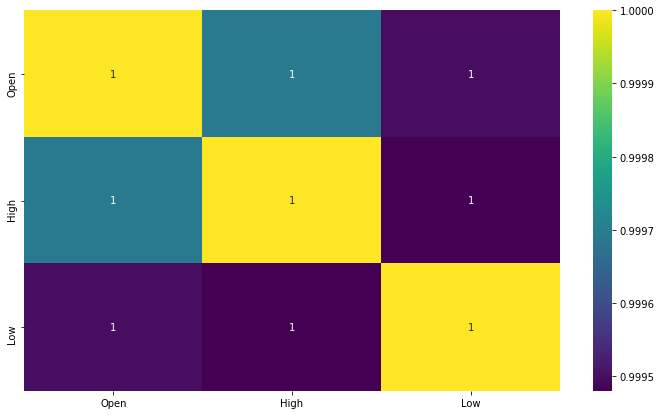

In [7]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

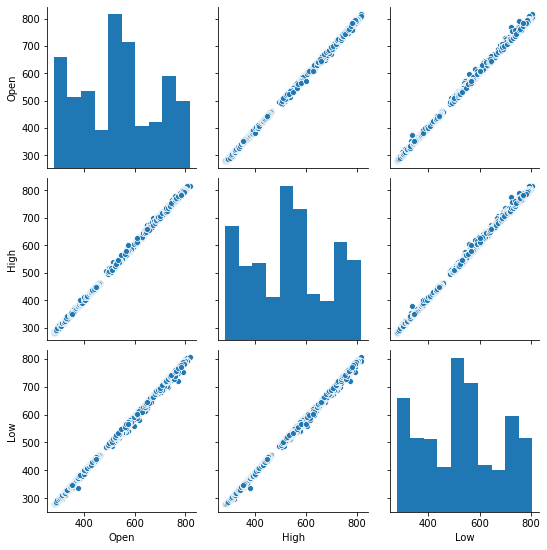

In [8]:
sns.pairplot(df)

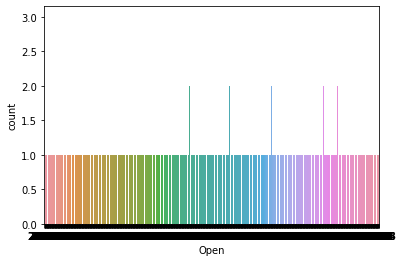

In [9]:
sns.countplot(x='Open',data=df)

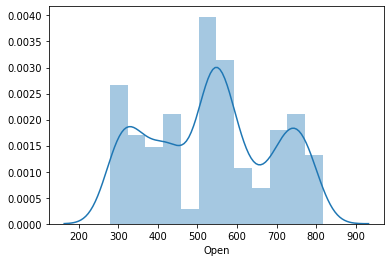

In [10]:
sns.distplot(df['Open'])

In [11]:
training_set = df.iloc[:,1:2].values

### Feature Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_sc = sc.fit_transform(training_set)

### Creating a data structure with 60 timesteps and 1 output

In [13]:
xtrain = []
ytrain = []

for i in range(60,1258):
  xtrain.append(training_set_sc[i-60:i, 0])
  ytrain.append(training_set_sc[i,0])

xtrain,ytrain = np.array(xtrain),np.array(ytrain)

In [14]:
#Reshaping
xtrain = np.reshape(xtrain,(xtrain.shape[0], xtrain.shape[1], 1))

## Building and Training the RNN

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [16]:
#Initialising the RNN
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (xtrain.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

### Compiling the RNN

In [17]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [18]:
regressor.fit(xtrain, ytrain, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0403
Epoch 2/100
38/38 [==============================] - 4s 112ms/step - loss: 0.0060
Epoch 3/100
38/38 [==============================] - 4s 117ms/step - loss: 0.0050
Epoch 4/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 4s 115ms/step - loss: 0.0048
Epoch 6/100
38/38 [==============================] - 4s 118ms/step - loss: 0.0043
Epoch 7/100
38/38 [==============================] - 4s 118ms/step - loss: 0.0043
Epoch 8/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 4s 113ms/step - loss: 0.0046
Epoch 10/100
38/38 [==============================] - 4s 111ms/step - loss: 0.0041
Epoch 11/100
38/38 [==============================] - 4s 113ms/step - loss: 0.0047
Epoch 12/100
38/38 [==============================] - 4s 114ms/step - loss: 0.0042
Epoch 13/100


### Making the predictions and visualising the results

In [19]:
#Getting the real stock price of 2017
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [20]:
#Getting the predicted stock price of 2017
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

xtest = []
for i in range(60, 80):
    xtest.append(inputs[i-60:i, 0])
xtest = np.array(xtest)
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

predicted_stock_price = regressor.predict(xtest)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualising the results

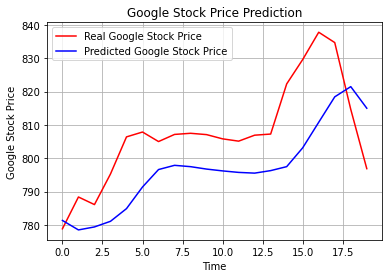

In [21]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.grid(True)
plt.legend()
plt.show()